# Stock Market Prediction

This notebook shows the example workflow for financial data time series analysis.

In [385]:
#%load_ext autoreload
#%autoreload 2
%matplotlib inline
%config InlineBackend.figure_format = 'retina'


# basic functionalities
import re
import os
import sys
import datetime
import itertools
import math 


# data transforamtion and manipulation
import pandas as pd
import pandas_datareader.data as web
import numpy as np
# prevent crazy long pandas prints
pd.options.display.max_columns = 16
pd.options.display.max_rows = 16
pd.set_option('display.float_format', lambda x: '%.5f' % x)
np.set_printoptions(precision=5, suppress=True)


# remove warnings
import warnings
warnings.filterwarnings('ignore')


# plotting and plot styling
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
plt.style.use('seaborn')
#sns.set_style("whitegrid", {'axes.grid' : False})
#set_matplotlib_formats('pdf', 'png')
plt.rcParams['savefig.dpi'] = 80
plt.rcParams['figure.autolayout'] = False
plt.rcParams['figure.figsize'] = (16, 8)
plt.rcParams['axes.labelsize'] = 16
plt.rcParams['axes.labelweight'] = 'bold'
plt.rcParams['axes.titlesize'] = 20
plt.rcParams['axes.titleweight'] = 'bold'
plt.rcParams['font.size'] = 16
plt.rcParams['lines.linewidth'] = 2.0
plt.rcParams['lines.markersize'] = 8
plt.rcParams['legend.fontsize'] = 14
plt.rcParams['text.usetex'] = False
#plt.rcParams['font.family'] = "serif"
plt.rcParams['font.serif'] = "cm"
plt.rcParams['text.latex.preamble'] = b"\usepackage{subdepth}, \usepackage{type1cm}"


# deep learning
from keras.models import Sequential
from keras.layers import Dense
from keras.utils import plot_model 
from tensorflow import set_random_seed


# jupyter wdgets
from ipywidgets import interactive, widgets, RadioButtons, ToggleButtons, Select, FloatSlider, FloatProgress
from IPython.display import set_matplotlib_formats, Image

## Download Historical Data

Financial time series can be downloaded using the Yahoo! Finance API which becomes easily accessible with the <code>pandas_datareader</code> library.

In [239]:
# define arguments
tickers = ['AAPL', 'AMZN', 'FB', 'GOOG', 'NFLX', '^GSPC']
provider = 'yahoo'
start = datetime.datetime(2008, 1, 1)
end = datetime.date(2017, 9, 21)

In [76]:
# ask Yahoo! Finance for data and save to DataFrame
data = web.DataReader(tickers, 'yahoo', start, end)['Adj Close']

# save data to a .csv
data.to_csv('./data/stock_data.csv', sep=';')

# show the data
data.head()

,AAPL,AMZN,FB,GOOG,NFLX,^GSPC
Date,,,,,,
1999-12-31,3.30342,76.12500,nan,nan,nan,1469.25000
2000-01-03,3.59662,89.37500,nan,nan,nan,1455.21997
2000-01-04,3.29338,81.93750,nan,nan,nan,1399.42004
2000-01-05,3.34158,69.75000,nan,nan,nan,1402.10999
2000-01-06,3.05240,65.56250,nan,nan,nan,1403.44995


In [321]:
df = pd.read_csv('./data/stock_data.csv', sep=';', header=0, parse_dates=True, index_col=0)

In [322]:
df.head()

,AAPL,AMZN,FB,GOOG,NFLX,^GSPC
Date,,,,,,
1999-12-31,3.30342,76.12500,nan,nan,nan,1469.25000
2000-01-03,3.59662,89.37500,nan,nan,nan,1455.21997
2000-01-04,3.29338,81.93750,nan,nan,nan,1399.42004
2000-01-05,3.34158,69.75000,nan,nan,nan,1402.10999
2000-01-06,3.05240,65.56250,nan,nan,nan,1403.44995


If the <code>DateFrame</code> is not explicitly invoked, this would create a <code>Series</code> object.

In [323]:
# only date and Netflix adjusted closing prices
df = pd.DataFrame(df.loc[start:, 'AMZN'])

In [324]:
# rename columns
df.columns = ['prices']

In [325]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2449 entries, 2008-01-02 to 2017-09-21
Data columns (total 1 columns):
prices    2449 non-null float64
dtypes: float64(1)
memory usage: 38.3 KB


In [326]:
pd.__version__

'0.20.1'

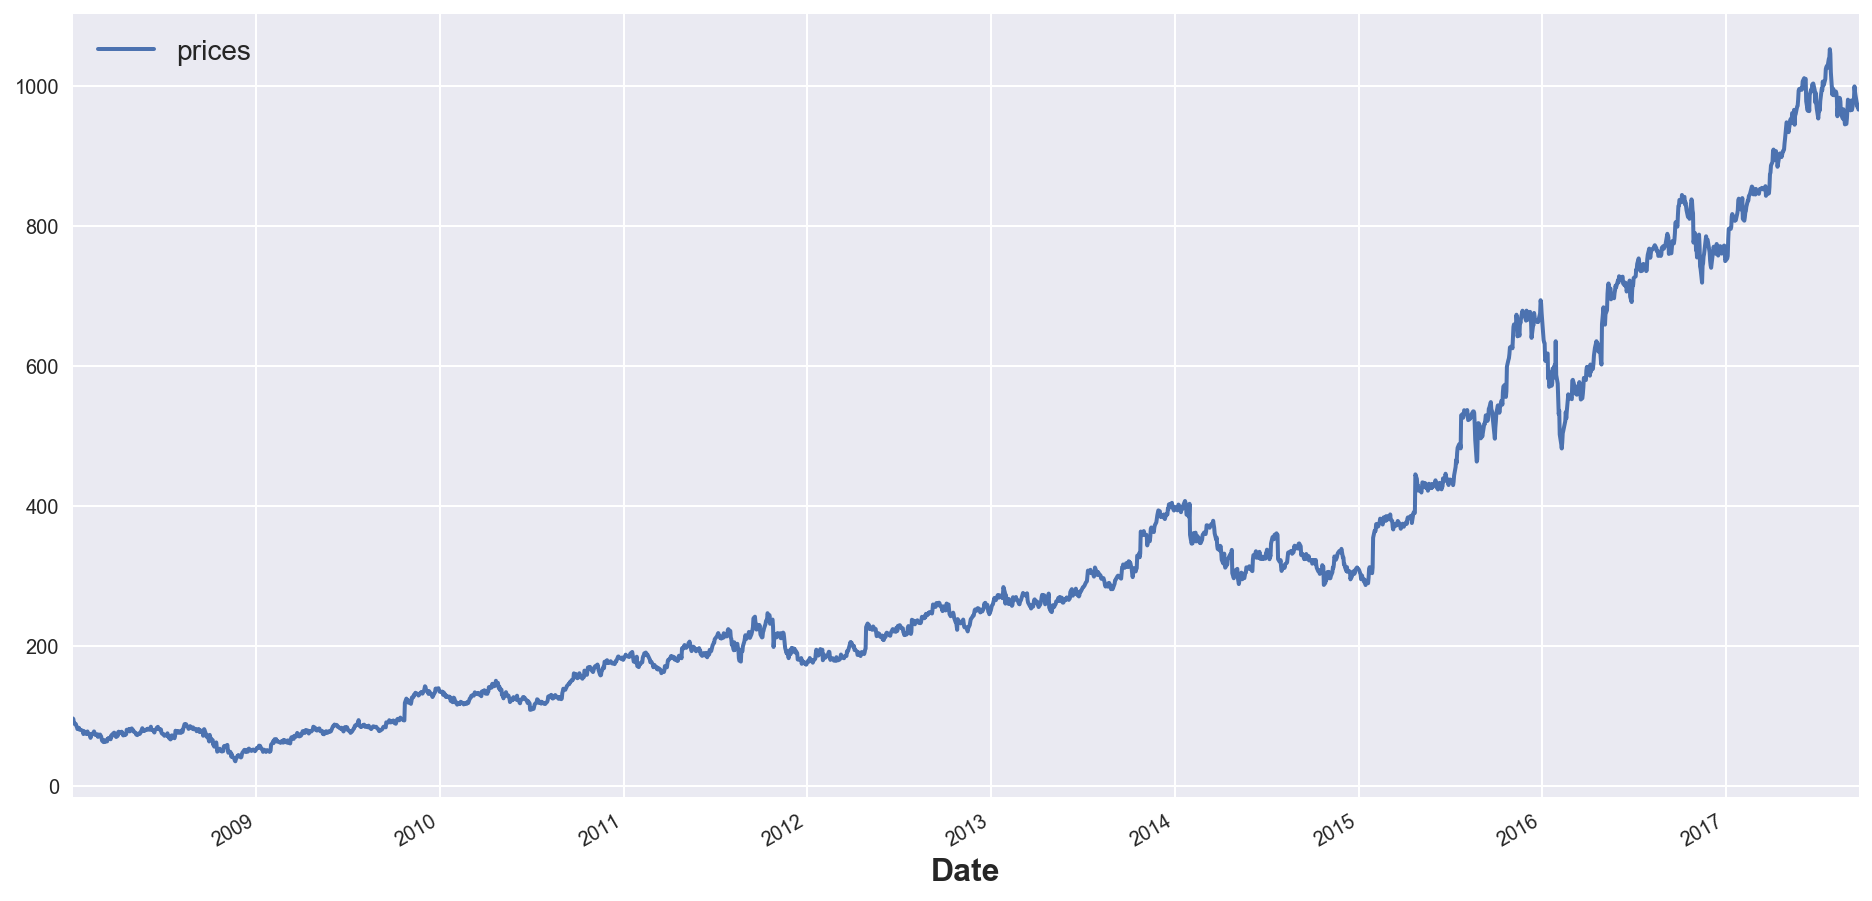

In [327]:
df.plot();

In [328]:
df['returns'] = np.log(df / df.shift(1))

In [329]:
df.head()

,prices,returns
Date,,
2008-01-02,96.25000,nan
2008-01-03,95.21000,-0.01086
2008-01-04,88.79000,-0.06981
2008-01-07,88.82000,0.00034
2008-01-08,87.88000,-0.01064


In [330]:
def create_data_set(df, lags=1):
    """
    For given df transform into lagged dataset
    """
    cols = []
    for lag in range(1, lags+1):
        col = 'lag_%d' % lag
        df[col] = df['returns'].shift(lag)
        cols.append(col)
        
    return df, cols

In [331]:
# define lags
lags=5

# create new data
df, cols = create_data_set(df, lags=lags)

In [332]:
df.head(10)

,prices,returns,lag_1,lag_2,lag_3,lag_4,lag_5
Date,,,,,,,
2008-01-02,96.25000,nan,nan,nan,nan,nan,nan
2008-01-03,95.21000,-0.01086,nan,nan,nan,nan,nan
2008-01-04,88.79000,-0.06981,-0.01086,nan,nan,nan,nan
2008-01-07,88.82000,0.00034,-0.06981,-0.01086,nan,nan,nan
2008-01-08,87.88000,-0.01064,0.00034,-0.06981,-0.01086,nan,nan
2008-01-09,85.22000,-0.03074,-0.01064,0.00034,-0.06981,-0.01086,nan
2008-01-10,84.26000,-0.01133,-0.03074,-0.01064,0.00034,-0.06981,-0.01086
2008-01-11,81.08000,-0.03847,-0.01133,-0.03074,-0.01064,0.00034,-0.06981
2008-01-14,82.87000,0.02184,-0.03847,-0.01133,-0.03074,-0.01064,0.00034


In [333]:
df.dropna(inplace=True)

In [334]:
df.head()

,prices,returns,lag_1,lag_2,lag_3,lag_4,lag_5
Date,,,,,,,
2008-01-10,84.26000,-0.01133,-0.03074,-0.01064,0.00034,-0.06981,-0.01086
2008-01-11,81.08000,-0.03847,-0.01133,-0.03074,-0.01064,0.00034,-0.06981
2008-01-14,82.87000,0.02184,-0.03847,-0.01133,-0.03074,-0.01064,0.00034
2008-01-15,80.24000,-0.03225,0.02184,-0.03847,-0.01133,-0.03074,-0.01064
2008-01-16,80.35000,0.00137,-0.03225,0.02184,-0.03847,-0.01133,-0.03074


## OLS Regression

In [335]:
reg = np.linalg.lstsq(df[cols].values, np.sign(df['returns'].values))[0]

In [336]:
reg

array([-1.1648 , -1.95857, -0.29311, -0.69045,  0.1117 ])

In [337]:
pred = np.sign(np.dot(df[cols].values, reg))

In [338]:
pred

array([ 1.,  1.,  1., ...,  1.,  1.,  1.])

In [339]:
np.sign(df['returns'].values)

array([-1., -1.,  1., ..., -1.,  1., -1.])

In [340]:
df['ols_pred'] = pred

In [341]:
c = np.sign(df['returns'] * df['ols_pred'])

In [342]:
c.value_counts()

1.00000     1283
-1.00000    1154
0.00000        6
dtype: int64

In [343]:
c.value_counts()[1] / (c.value_counts().sum())

0.52517396643471137

In [344]:
df['ols_returns'] = df['returns'] * df['ols_pred']

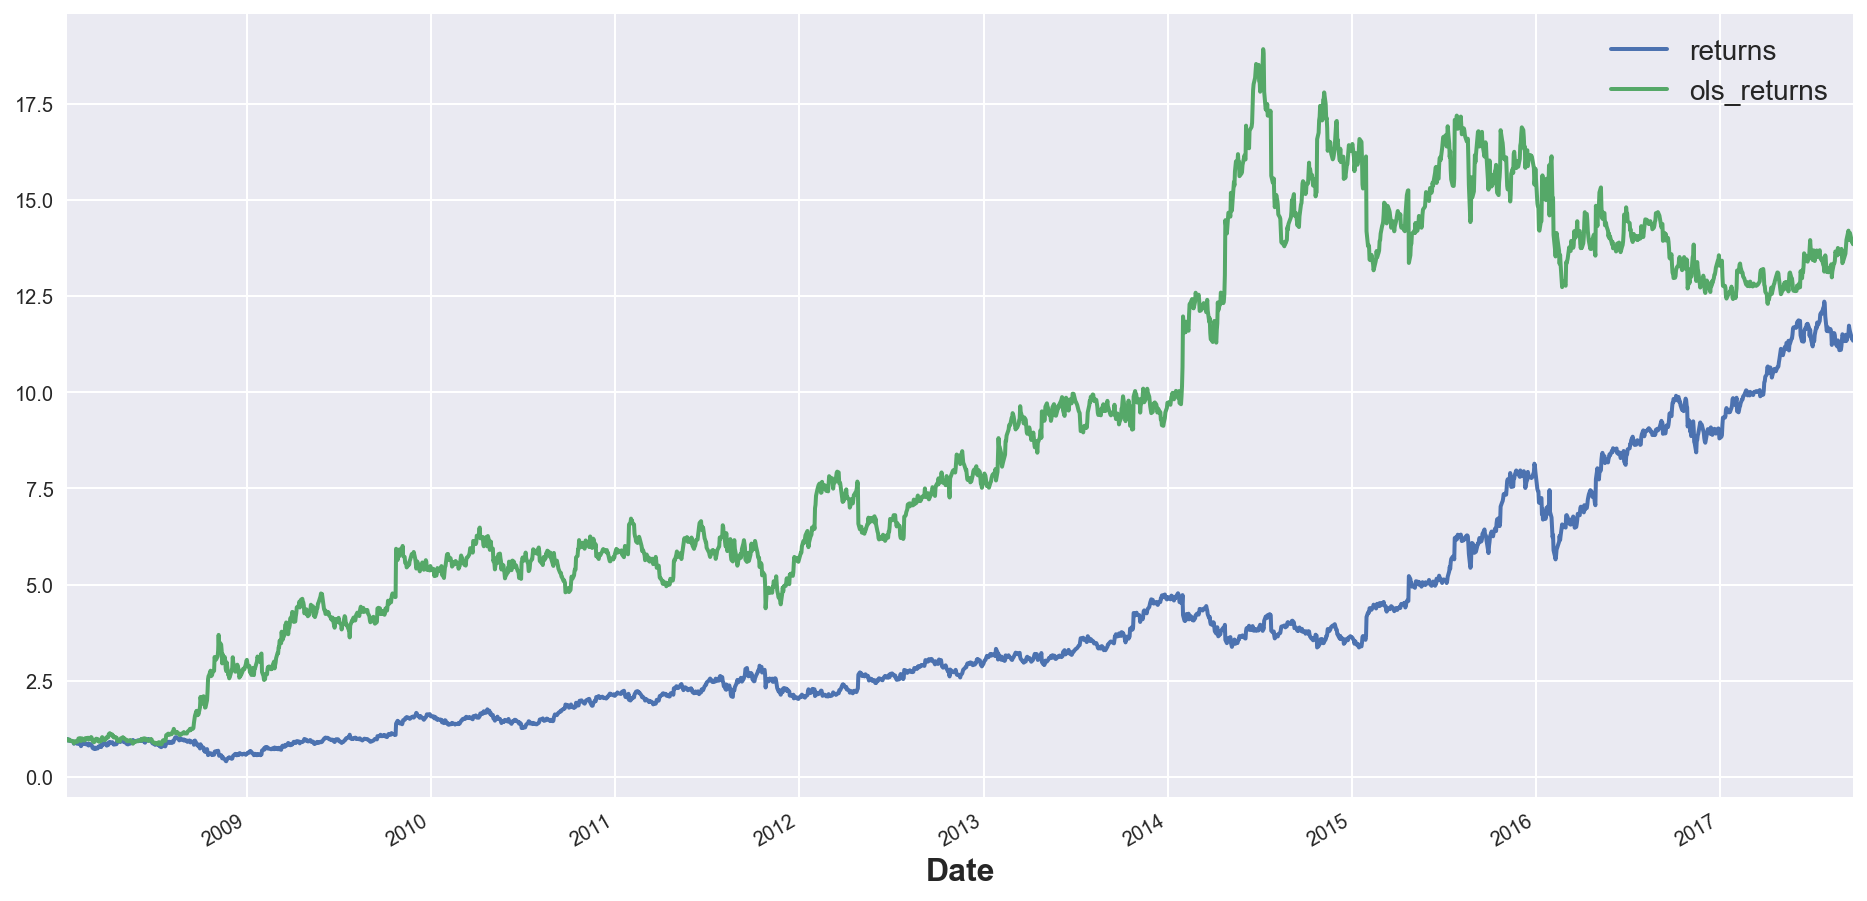

In [345]:
df[['returns', 'ols_returns']].cumsum().apply(np.exp).plot()

## Logistic Regression

In [346]:
from sklearn import linear_model

In [347]:
lm = linear_model.LogisticRegression(C = 1e3)

In [348]:
lm.fit(df[cols], np.sign(df['returns']))

LogisticRegression(C=1000.0, class_weight=None, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)

In [349]:
df['log_pred'] = lm.predict(df[cols])

In [350]:
df.head()

,prices,returns,lag_1,lag_2,lag_3,lag_4,lag_5,ols_pred,ols_returns,log_pred
Date,,,,,,,,,,
2008-01-10,84.26000,-0.01133,-0.03074,-0.01064,0.00034,-0.06981,-0.01086,1.00000,-0.01133,1.00000
2008-01-11,81.08000,-0.03847,-0.01133,-0.03074,-0.01064,0.00034,-0.06981,1.00000,-0.03847,1.00000
2008-01-14,82.87000,0.02184,-0.03847,-0.01133,-0.03074,-0.01064,0.00034,1.00000,0.02184,1.00000
2008-01-15,80.24000,-0.03225,0.02184,-0.03847,-0.01133,-0.03074,-0.01064,1.00000,-0.03225,1.00000
2008-01-16,80.35000,0.00137,-0.03225,0.02184,-0.03847,-0.01133,-0.03074,1.00000,0.00137,1.00000


In [351]:
df['log_returns'] = df['returns'] * df['log_pred']

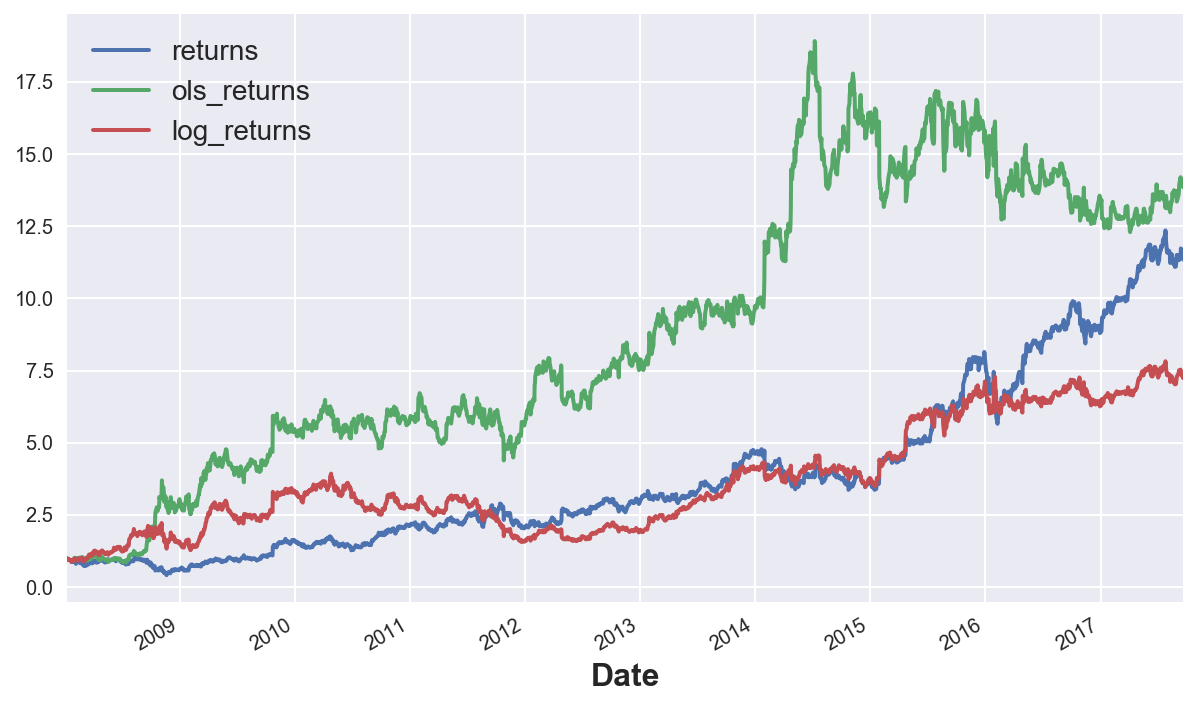

In [352]:
df[['returns', 'ols_returns', 'log_returns']].cumsum().apply(np.exp).plot(figsize=(10, 6));

# Deep Neural Network

In [386]:
import tensorflow as tf

In [387]:
tf.logging.set_verbosity(tf.logging.ERROR)

In [388]:
mean = df['returns'].mean()

In [389]:
std = df['returns'].std()

In [390]:
print(mean, std)

0.000993987154593634 0.02417630169332669


In [423]:
fc = tf.contrib.layers.real_valued_column('returns', dimension=lags)

In [424]:
fcb = [tf.contrib.layers.bucketized_column(fc,
                    boundaries=[-0.0005, 0.0001, 0.0005])]

In [425]:
# [5, 8, 12, 8] overtraining

model = tf.contrib.learn.DNNClassifier(hidden_units=[20, 40],
                                       feature_columns=fcb)

In [432]:
def get_data():
    fc = {'returns': tf.constant(df[cols].values)}
    la = tf.constant((df['returns'] > 0).astype(int).values,
                     shape=[len(df), 1])
    return fc, la

In [433]:
np.random.seed(2)
set_random_seed(2)
model.fit(input_fn=get_data, steps=100)

DNNClassifier(params={'head': <tensorflow.contrib.learn.python.learn.estimators.head._BinaryLogisticHead object at 0x000002A80A417780>, 'feature_columns': (_BucketizedColumn(source_column=_RealValuedColumn(column_name='returns', dimension=5, default_value=None, dtype=tf.float32, normalizer=None), boundaries=(-0.0005, 0.0001, 0.0005)),), 'input_layer_min_slice_size': None, 'optimizer': None, 'hidden_units': [20, 40], 'embedding_lr_multipliers': None, 'activation_fn': <function relu at 0x000002A873817378>, 'gradient_clip_norm': None, 'dropout': None})

In [434]:
model.evaluate(input_fn=get_data, steps=1)

{'accuracy': 0.52394599,
 'accuracy/baseline_label_mean': 0.511666,
 'accuracy/threshold_0.500000_mean': 0.52394599,
 'auc': 0.53744543,
 'auc_precision_recall': 0.55780256,
 'global_step': 200,
 'labels/actual_label_mean': 0.511666,
 'labels/prediction_mean': 0.51192498,
 'loss': 0.69024855,
 'precision/positive_threshold_0.500000_mean': 0.52949154,
 'recall/positive_threshold_0.500000_mean': 0.62480003}

In [435]:
df['dnn_pred'] = list(model.predict(input_fn=get_data))
df['dnn_pred'] = np.where(df['dnn_pred'] > 0, 1.0, -1.0)

In [436]:
df['dnn_returns'] = df['returns'] * df['dnn_pred']

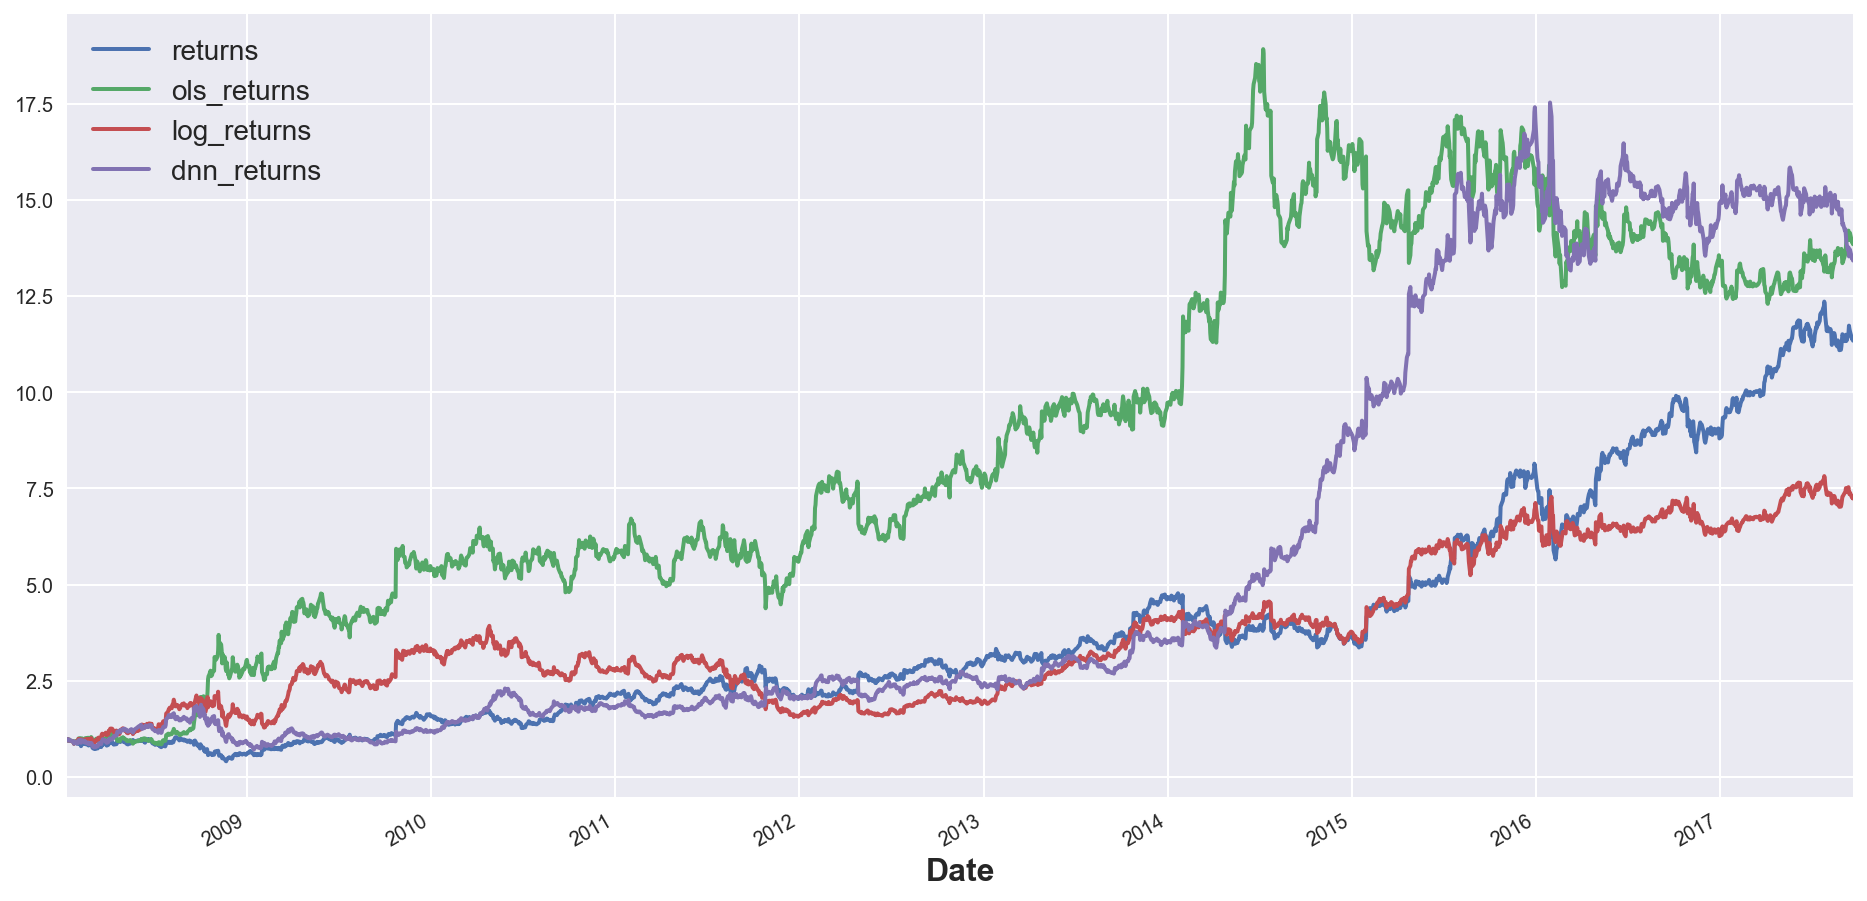

In [437]:
df[['returns', 'ols_returns', 'log_returns', 'dnn_returns']].cumsum().apply(np.exp).plot()
plt.show()

In [422]:
df

,prices,returns,lag_1,lag_2,lag_3,lag_4,lag_5,ols_pred,ols_returns,log_pred,log_returns,dnn_pred,dnn_returns
Date,,,,,,,,,,,,,
2008-01-10,84.26000,-0.01133,-0.03074,-0.01064,0.00034,-0.06981,-0.01086,1.00000,-0.01133,1.00000,-0.01133,1.00000,-0.01133
2008-01-11,81.08000,-0.03847,-0.01133,-0.03074,-0.01064,0.00034,-0.06981,1.00000,-0.03847,1.00000,-0.03847,1.00000,-0.03847
2008-01-14,82.87000,0.02184,-0.03847,-0.01133,-0.03074,-0.01064,0.00034,1.00000,0.02184,1.00000,0.02184,1.00000,0.02184
2008-01-15,80.24000,-0.03225,0.02184,-0.03847,-0.01133,-0.03074,-0.01064,1.00000,-0.03225,1.00000,-0.03225,1.00000,-0.03225
2008-01-16,80.35000,0.00137,-0.03225,0.02184,-0.03847,-0.01133,-0.03074,1.00000,0.00137,1.00000,0.00137,-1.00000,-0.00137
2008-01-17,80.12000,-0.00287,0.00137,-0.03225,0.02184,-0.03847,-0.01133,1.00000,-0.00287,1.00000,-0.00287,-1.00000,0.00287
2008-01-18,79.76000,-0.00450,-0.00287,0.00137,-0.03225,0.02184,-0.03847,-1.00000,0.00450,1.00000,-0.00450,1.00000,-0.00450
2008-01-22,78.48000,-0.01618,-0.00450,-0.00287,0.00137,-0.03225,0.02184,1.00000,-0.01618,1.00000,-0.01618,1.00000,-0.01618
...,...,...,...,...,...,...,...,...,...,...,...,...,...
